# SupplyChain class

## What is a SupplyChain object?

This tutorial shows how to use the `SupplyChain` class of CLIMADA. This class allows assessing indirect economic impacts via Input-Output (IO) based modeling. 

This tutorial assumes you are familiar with direct impact computation with CLIMADA with the [`Exposures`](https://climada-python.readthedocs.io/en/stable/tutorial/climada_entity_Exposures.html), [`Hazard`](https://climada-python.readthedocs.io/en/stable/tutorial/climada_hazard_Hazard.html) and [`Impact`](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_Impact.html) classes. Likewise, this tutorial assumes you are familiar with IO based modeling¹.

¹) We recommand the following book: Miller, R. E., & Blair, P. D. (2009). Input-Output Analysis: Foundations and Extensions (2nd ed.). Cambridge: Cambridge University Press. 

## Goal of this tutorial

The goal of this tutorial is to present **indirect** impact computation for the different available approaches, by presenting how to set up a global supply chain risk analysis for tropical cyclones hitting the United States and showing the.

## What approaches are availables?

Here, we **briefly** describe the available approaches. We **strongly** advise you to find more detailled documentation online or in the literature if you are not familiar with these concept.

### Leontief

The Leontief approach to conducting an indirect impact assessment involves using a Multi-Regional Input Output Table (MRIOT) to quantify the ripple effects of a **change in final demand** throughout the economy. The key steps are:

1. Obtain the Leontief inverse matrix from the intermediate demand matrix of the MRIOT (or transaction matrix), which represents the total (direct and indirect) requirements of each sector per unit of final demand. This captures the interdependencies between different sectors.
2. Multiply the Leontief inverse matrix by the change in final demand (the "exogenous variable") to calculate the indirect impacts on production in each sector.
3. The indirect effects analysis assesses the secondary needs arising from interactions among different sectors, considering the infinite iterations within the production system.
4. This allows for a comprehensive assessment of the indirect impacts beyond the first-order, direct impacts of the change in final demand.

### Ghosh

The Ghosh approach to conducting an indirect impact assessment is similar to the Leontief approach, but with some key differences:

1. The Ghosh model focuses on the supply-side of the economy, rather than the demand-side as in the Leontief model. It analyzes the impacts of changes in primary inputs (most often the value-added, which is what we use in the module) on the output of each sector.
2. The Ghosh inverse matrix represents the total (direct and indirect) output requirements per unit of primary input, capturing the forward linkages in the production system.
3. To assess the indirect impacts, the Ghosh inverse matrix is multiplied by the change in primary inputs (the "exogenous variable") to calculate the resulting changes in sectoral outputs.

Note however, that the Ghosh model has been criticized for its lack of economic plausibility, as it assumes that consumption is unresponsive to changes in income. Which is considered an unrealistic assumption.

### ARIO (with the `boario` package)

ARIO stands for Adaptive Regional Input-Output. It is an hybrid input-output / agent-based, dynamic economic model, designed to compute indirect costs from economic shocks. 
Its first version dates back to 2008 and has originally been developed to assess the indirect costs of natural disasters [[Hallegatte 2008](https://doi.org/10.1111/j.1539-6924.2008.01046.x), [Hallegatte 2013](https://doi.org/10.1111/risa.12090)].

CLIMADA employs the [`boario`](https://spjuhel.github.io/BoARIO/boario-what-is.html) python package which implements the ARIO model.

Here are its keys elements:

- The economy is modelled as a set of economic sectors and a set of regions (the initial equilibrium state of the economy is built based on a MRIOT).
- Each economic sector produces its generic product and draws inputs from an inventory.
- Each sector answers to a total demand consisting of a final demand (household consumption, public spending and private investments) of all regions (local demand and exports) and intermediate demand (through inputs inventory resupply).

Currently, with CLIMADA, two kinds of shocks can be implemented:

1. On the production capacity directly (one or multiple industries are arbitrarily forced to produce less)
2. On the productive capital (one or multiple industries arbitrarily lose some part of their factors of production and are thus forced to both produce less and to build back their capital stock).

The model then describes how exogenous shocks propagates across the economy at each time step.



## Tutorial

In [ ]:
import numpy as np
import pandas as pd

from climada.util.api_client import Client
from climada_petals.engine import SupplyChain
from climada.entity import ImpfTropCyclone, ImpactFuncSet
from climada.engine.impact_calc import ImpactCalc
import datetime as dt

client = Client()

### 1. Calculate direct economic impacts

The first step is to conduct a direct impact analysis. To do so, we need to define an exposure, an hazard and a vulnerability. In this tutorial we will load the LitPop exposure for the USA from CLIMADA Data API.

In [ ]:
exp_usa = client.get_litpop('USA')

Then, we load tropical cyclones that hit the USA in 2017 from the CLIMADA Data API.

In [ ]:
tc_usa = client.get_hazard('tropical_cyclone', properties={'country_iso3alpha':'USA', 'event_type': 'observed'})

target_year = 2017
events_in_target_year = np.array([
    tc_usa.event_name[i] for i in range(len(tc_usa.event_name)) if 
    dt.datetime.fromordinal(tc_usa.date[i]).year == target_year
    ])

tc_usa_target_year = tc_usa.select(event_names = events_in_target_year)

Then we define vulnerability by loading impact functions for tropical cyclone in the USA:

In [5]:
# Define impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

And we finally calculate impacts.

In [6]:
# Calculate direct impacts to the USA due to TC
imp_calc = ImpactCalc(exp_usa, impf_set, tc_usa_target_year)
direct_impact_usa = imp_calc.impact()

2024-04-24 14:39:37,395 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2024-04-24 14:39:37,414 - climada.entity.exposures.base - INFO - Matching 643099 exposures with 610031 centroids.
2024-04-24 14:39:37,498 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-04-24 14:39:38,393 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 19942 coordinates.
2024-04-24 14:39:38,416 - climada.engine.impact_calc - INFO - Calculating impact for 1414728 assets (>0) and 106 events.


### 2. Calculate indirect economic impacts

#### 2.1 Instantiate a `SupplyChain` object by loading the Multi-Regional Input-Output Table of interest

Currently a `SupplyChain` object allows to computes indirect economic impacts with different Input-Output (IO) based modeling approaches. At the core of IO modeling lies an Input-Output Table. `SupplyChain` uses the [pymrio](https://pymrio.readthedocs.io/en/latest/) python package to download, parse and save Multi-Regional Input Output Tables (MRIOTs). In principle, any IO table can be loaded and used, as long as the structure is consistent with those internally supported by `SupplyChain`, which are:
- [EXIOBASE3](https://zenodo.org/record/3583071#.Y_4zZuzMK3I) (1995-2011; 44 countries; 163 industries)
- [WIOD16](https://www.rug.nl/ggdc/valuechain/wiod/) (2000-2014; 43 countries; 56 industries)
- [OECD21](https://www.oecd.org/sti/ind/inter-country-input-output-tables.htm) (1995-2018; 66 countries; 45 industries)

These MRIOTs can be downloaded, parsed and saved automatically.

The first step is to instantiate a `SupplyChain` class. This can be done by passing a customized MRIOT or by calling the `from_mriot` class method to use one of the supported MRIOTs.

In [ ]:
supchain = SupplyChain.from_mriot(mriot_type='WIOD16', mriot_year=2011)

The instatiated class now has an `mriot` attribute, which is a pymrio `IOSystem` object. As such, one can access several info of the MRIOT including regions, sectors, total production, transaction matrix and final demand. Please see [pymrio's documentation](https://pymrio.readthedocs.io/) on how to make best use of all the provided functions.

For example, one can access regions, sectors and IOT data:

In [8]:
# regions
supchain.mriot.get_regions()

Index(['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'CHE', 'CHN', 'CYP', 'CZE',
       'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN',
       'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA', 'MEX',
       'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'SWE',
       'TUR', 'TWN', 'USA', 'ROW'],
      dtype='object', name='region')

In [9]:
# sectors
supchain.mriot.get_sectors()

Index(['Crop and animal production, hunting and related service activities',
       'Forestry and logging', 'Fishing and aquaculture',
       'Mining and quarrying',
       'Manufacture of food products, beverages and tobacco products',
       'Manufacture of textiles, wearing apparel and leather products',
       'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials',
       'Manufacture of paper and paper products',
       'Printing and reproduction of recorded media',
       'Manufacture of coke and refined petroleum products ',
       'Manufacture of chemicals and chemical products ',
       'Manufacture of basic pharmaceutical products and pharmaceutical preparations',
       'Manufacture of rubber and plastic products',
       'Manufacture of other non-metallic mineral products',
       'Manufacture of basic metals',
       'Manufacture of fabricated metal products, except machinery and equipment',
       

In [10]:
# transaction matrix
supchain.mriot.Z

region                                                                                                                   AUS  \
sector                                                    Crop and animal production, hunting and related service activities   
region sector                                                                                                                  
AUS    Crop and animal production, hunting and related...                                       10954.209508                   
       Forestry and logging                                                                       113.905445                   
       Fishing and aquaculture                                                                     22.267974                   
       Mining and quarrying                                                                       232.437685                   
       Manufacture of food products, beverages and tob...                                        1662.225516                   
...                                                                                                      ...                   
ROW    Education                                                                                    1.305193                   
       Human health and social work activities                                                      0.535337                   
       Other service activities                                                                     1.856064                   
       Activities of households as employers; undiffer...                                           0.027816                   
       Activities of extraterritorial organizations an...                                           0.000000                   

region                                                                          \
sector                                                    Forestry and logging   
region sector                                                                    
AUS    Crop and animal production, hunting and related...           337.318807   
       Forestry and logging                                         127.867760   
       Fishing and aquaculture                                        0.025312   
       Mining and quarrying                                           2.323883   
       Manufacture of food products, beverages and tob...             4.046841   
...                                                                        ...   
ROW    Education                                                      0.022124   
       Human health and social work activities                        0.038688   
       Other service activities                                       0.058495   
       Activities of households as employers; undiffer...             0.000064   
       Activities of extraterritorial organizations an...             0.000000   

region                                                                             \
sector                                                    Fishing and aquaculture   
region sector                                                                       
AUS    Crop and animal production, hunting and related...              166.404066   
       Forestry and logging                                              0.588653   
       Fishing and aquaculture                                          21.871529   
       Mining and quarrying                                              8.353050   
       Manufacture of food products, beverages and tob...               78.987732   
...                                                                           ...   
ROW    Education                                                         0.093113   
       Human health and social work activities                           0.141195   
       Other service activities                                          0.149588   
       Activities of households as emp

In [11]:
# final demand
supchain.mriot.Y

region                                                                                            AUS  \
category                                                  Final consumption expenditure by households   
region sector                                                                                           
AUS    Crop and animal production, hunting and related...                                 7574.242904   
       Forestry and logging                                                                179.441312   
       Fishing and aquaculture                                                            1110.343558   
       Mining and quarrying                                                               3271.376748   
       Manufacture of food products, beverages and tob...                                32371.160467   
...                                                                                               ...   
ROW    Education                                                                            77.238254   
       Human health and social work activities                                              77.839965   
       Other service activities                                                             70.302003   
       Activities of households as employers; undiffer...                                   10.406364   
       Activities of extraterritorial organizations an...                                    0.000000   

region                                                                                                                                          \
category                                                  Final consumption expenditure by non-profit organisations serving households (NPISH)   
region sector                                                                                                                                    
AUS    Crop and animal production, hunting and related...                                                  0                                     
       Forestry and logging                                                                                0                                     
       Fishing and aquaculture                                                                             0                                     
       Mining and quarrying                                                                                0                                     
       Manufacture of food products, beverages and tob...                                                  0                                     
...                                                                                                      ...                                     
ROW    Education                                                                                           0                                     
       Human health and social work activities                                                             0                                     
       Other service activities                                                                            0                                     
       Activities of households as employers; undiffer...                                                  0                                     
       Activities of extraterritorial organizations an...                                                  0                                     

region                                                                                                 \
category                                                  Final consumption expenditure by government   
region sector                                                                                           
AUS    Crop and animal production, hunting and related...                                  405.543798   
       Forestry and logging                                     

In [12]:
# total production
supchain.mriot.x

indout
region sector                                                           
AUS    Crop and animal production, hunting and related...   69566.630223
       Forestry and logging                                  2719.293635
       Fishing and aquaculture                               3113.703184
       Mining and quarrying                                250207.439236
       Manufacture of food products, beverages and tob...   92033.592425
...                                                                  ...
ROW    Education                                           508147.713351
       Human health and social work activities             399362.733830
       Other service activities                            367396.468789
       Activities of households as employers; undiffer...   22003.013824
       Activities of extraterritorial organizations an...      33.142482

[2464 rows x 1 columns]

#### 2.2 Assign stock exposure and impact to MRIOT countries-sectors

After loading the MRIOT, you need to translate the direct impacts previously calculated&mdash;which are defined at an arbitrary spatial resolution&mdash;into impacts to sectors and countries defined by the MRIOT. To do this you need to map the geographic exposure and impact to a) the countries and b) the sectors of the MRIOT. 

Mapping to countries is straightforward, as exposure contains latitude and longitude information, and even a regional id that often defines the country of interest. This is done automatically for EXIOBASE3, WIOD16 and OECD21 MRIOTs, but currently requires you to do it for other or custom MRIOTs.

Mapping to sectors is done by selecting the sectors assumed to be impacted. The default is to assume all sectors are impacted, although we highly recommend you to make an explicit choice here.

In this example, assuming the `LitPop` exposure is representative of the service sector, and assuming that sub-sectors at positions 26 to 56 in `WIOD16` do represent this sector, we translate spatially disaggregated impacts into country/sector impacts as follows:

In [13]:
impacted_secs = supchain.mriot.get_sectors()[range(26,56)].tolist()
supchain.calc_shock_to_sectors(exp_usa, direct_impact_usa, impacted_secs)

Which creates the attributes `secs_exp`, `secs_imp`, and `secs_shock`. 

The first two show `Exposure` and `Impact` values at the country-sector level. This translation is accomplished assuming that exposure/impact of an affected sector is proportional to this sector's contribution to the overall production of all affected sectors. For example, if the total (spatially distributed) exposed value is 100, and there are two affected sectors, `A` (whose production is 2) and `B` (whose production is 8), then sector `A` has an exposure of 20 and sector `B` has an exposure of 80. The same reasoning is applied to the distributions of direct impacts.

Numbers in `secs_exp`, `secs_imp` are expressed **in the same unit** as the used MRIOT.

The unit can be checked by doing:

In [14]:
supchain.mriot.unit

unit
region sector                                                   
AUS    Crop and animal production, hunting and related...  M.USD
       Forestry and logging                                M.USD
       Fishing and aquaculture                             M.USD
       Mining and quarrying                                M.USD
       Manufacture of food products, beverages and tob...  M.USD
...                                                          ...
ROW    Education                                           M.USD
       Human health and social work activities             M.USD
       Other service activities                            M.USD
       Activities of households as employers; undiffer...  M.USD
       Activities of extraterritorial organizations an...  M.USD

[2464 rows x 1 columns]

The derived conversion factor for the used MRIOT unit is also accessible via:

In [15]:
supchain.conversion_factor()

1000000.0

Then one can easily check that `secs_exp`, `secs_imp` have the same total values¹ of `Exposure` and `Impact` and that this only involves the directly hit countries-sectors :

In [16]:
# exposure
print(
      exp_usa.gdf.value.sum() / supchain.conversion_factor(),
      "==",
      supchain.secs_exp.sum().sum(),
      "==",
      supchain.secs_exp.loc[:, ('USA', impacted_secs)].sum().sum(),
      )

# impact
print(
      direct_impact_usa.imp_mat.sum().sum() / supchain.conversion_factor(),
      "==",
      supchain.secs_imp.sum().sum(),
      "==",
      supchain.secs_imp.loc[:, ('USA', impacted_secs)].sum().sum(),
      )

65384554.30441263 == 65384554.30441265 == 65384554.30441265
141034.65122888522 == 141034.65122888575 == 141034.65122888578


¹) Note that we observe minor differences (below 1$ here) which are due to numerical errors.

The attribute `secs_shock` is the ratio between `secs_imp` and `secs_exp`. `secs_shock` is used in the indirect impact calculation to assess how the loss of assets is experienced by each sector (loss of production capacity, loss of final demand, etc.).

In terms of structure, `secs_shock` is a dataframe with a (regions,sectors) MultiIndex as columns, and the ids of the hazard events that have *non-zero impacts* as index:

In [17]:
supchain.secs_shock.loc[:, ('USA', impacted_secs)].head()

region            USA  \
sector   Construction   
event_id                
1446         0.000002   
1452         0.000074   
1454         0.002068   
1459         0.000012   

region                                                                            \
sector   Wholesale and retail trade and repair of motor vehicles and motorcycles   
event_id                                                                           
1446                                               0.000002                        
1452                                               0.000074                        
1454                                               0.002068                        
1459                                               0.000012                        

region                                                              \
sector   Wholesale trade, except of motor vehicles and motorcycles   
event_id                                                             
1446                                               0.000002          
1452                                               0.000074          
1454                                               0.002068          
1459                                               0.000012          

region                                                           \
sector   Retail trade, except of motor vehicles and motorcycles   
event_id                                                          
1446                                               0.000002       
1452                                               0.000074       
1454                                               0.002068       
1459                                               0.000012       

region                                                               \
sector   Land transport and transport via pipelines Water transport   
event_id                                                              
1446                                       0.000002        0.000002   
1452                                       0.000074        0.000074   
1454                                       0.002068        0.002068   
1459                                       0.000012        0.000012   

region                                                                        \
sector   Air transport Warehousing and support activities for transportation   
event_id                                                                       
1446          0.000002                                           0.000002      
1452          0.000074                                           0.000074      
1454          0.002068                                           0.002068      
1459          0.000012                                           0.000012      

region                                  \
sector   Postal and courier activities   
event_id                                 
1446                          0.000002   
1452                          0.000074   
1454                          0.002068   
1459                          0.000012   

region                                              ...  \
sector   Accommodation and food service activities  ...   
event_id                                            ...   
1446                                      0.000002  ...   
1452                                      0.000074  ...   
1454                                      0.002068  ...   
1459                                      0.000012  ...   

region                                                                        \
sector   Scientific research and development Advertising and market research   
event_id                                                                       
1446                                0.000002                        0.000002   
1452                                0.000074                        0.000074   
1454                                0.002068                        0.002068   
1459                      

By default, `shock_factor` is 1 and `secs_shock` is exactly the ratio between `Impact` and `Exposure`, which results in the same shock across sectors for a given event:

In [18]:
# let's try the first three events
for event_id in supchain.secs_shock.index[:3]:
    imp_event = direct_impact_usa.at_event[direct_impact_usa.event_id == event_id][0]
    print(imp_event / exp_usa.gdf.value.sum(), "==", supchain.secs_shock.loc[event_id, ('USA', impacted_secs)].values[0])

2.2637154189066715e-06 == 2.2637154189066715e-06
7.434784063419168e-05 == 7.434784063419166e-05
0.002068242123595854 == 0.0020682421235958537


This practically means that the fraction of *flow* losses (on production/demand depending on the subsequent approach used) is assumed to be equal to the fraction of *stock* losses, since `Impact` and `Exposure` typically refer to stocks in CLIMADA. However, since depending on the sector one can reasonably expect production losses to be proportionally higher or lower than stock losses, a `shock_factor` argument can also be passed to `calc_shock_to_sectors` to define&mdash;for each sector&mdash;how much should flow shocks be higher/lower than stocks shocks (i.e., the mere `Impact` / `Exposure` ratio).

Here is an example on how to define a custom shock factor:

In [19]:
shock_factor = pd.DataFrame(np.repeat(1, supchain.mriot.x.shape[0]), 
                            index=supchain.mriot.x.index,
                            columns=['shock'], dtype="float64")

# randomly generated for this tutorial
shock_facs_service_USA = np.array([
                                   0.38324804, 1.15930626, 0.73846477, 0.5430206 , 0.54147014,
                                   0.28362671, 0.53829353, 1.95367016, 1.33675622, 0.42285787,
                                   0.86974667, 1.4685637 , 1.24804793, 0.56915521, 0.43723048,
                                   0.23372398, 0.69268485, 0.74130451, 0.74739106, 1.18719852,
                                   1.02203697, 1.0412411 , 0.09315484, 1.23612412, 0.55947349,
                                   0.8608431, 0.58983156, 1.13137055, 0.93014364, 0.39092134
                                   ])

shock_factor.loc[('USA', impacted_secs), :] = shock_facs_service_USA

# supply shock factors when calculating sectorial shocks
supchain.calc_shock_to_sectors(exp_usa, direct_impact_usa, impacted_secs, shock_factor.values.flatten())

In [20]:
supchain.secs_shock.loc[:, ('USA', impacted_secs)].head()

region             USA  \
sector    Construction   
event_id                 
1446      8.675645e-07   
1452      2.849366e-05   
1454      7.926497e-04   
1459      4.656036e-06   

region                                                                            \
sector   Wholesale and retail trade and repair of motor vehicles and motorcycles   
event_id                                                                           
1446                                               0.000003                        
1452                                               0.000086                        
1454                                               0.002398                        
1459                                               0.000014                        

region                                                              \
sector   Wholesale trade, except of motor vehicles and motorcycles   
event_id                                                             
1446                                               0.000002          
1452                                               0.000055          
1454                                               0.001527          
1459                                               0.000009          

region                                                           \
sector   Retail trade, except of motor vehicles and motorcycles   
event_id                                                          
1446                                               0.000001       
1452                                               0.000040       
1454                                               0.001123       
1459                                               0.000007       

region                                                               \
sector   Land transport and transport via pipelines Water transport   
event_id                                                              
1446                                       0.000001    6.420502e-07   
1452                                       0.000040    2.108703e-05   
1454                                       0.001120    5.866087e-04   
1459                                       0.000007    3.445748e-06   

region                                                                        \
sector   Air transport Warehousing and support activities for transportation   
event_id                                                                       
1446          0.000001                                           0.000004      
1452          0.000040                                           0.000145      
1454          0.001113                                           0.004041      
1459          0.000007                                           0.000024      

region                                  \
sector   Postal and courier activities   
event_id                                 
1446                          0.000003   
1452                          0.000099   
1454                          0.002765   
1459                          0.000016   

region                                              ...  \
sector   Accommodation and food service activities  ...   
event_id                                            ...   
1446                                  9.572299e-07  ...   
1452                                  3.143857e-05  ...   
1454                                  8.745725e-04  ...   
1459                                  5.137251e-06  ...   

region                                                                        \
sector   Scientific research and development Advertising and market research   
event_id                                                                       
1446                                0.000002                        0.000002   
1452                                0.000076                        0.000077   
1454                                0.002114                        0.002154   
1459               

Even though the default values (all one) for the shock factors are correct only in the (uncommon) case in which CLIMADA's direct impacts already express production losses, a proper assignment of the shock factors requires extensive expert knowledge. Therefore, it is recommended to change these values only when detailed knowledge about the relationship between stock and flow losses is available.

#### 2.3 Calculate the propagation of production losses with Ghosh and Leontief approaches

After sectorial shocks are defined, you can compute how these propagate through the supply chain. This can be done with the via the `calc_impacts` method by specifying the approach you want (`ghosh`, `leontief`, `eeioa` or `boario`). 

In the following we focus on the `ghosh` and `leontief` approach. For the `boario` approach see the [BoARIO](#2.4-Calculate-the-propagation-of-production-losses-with-the-boario-approach) section.

All approaches can be run on the same instantiation of `SupplyChain` and results are stored in a dictionary attribute `supchain_imp` with keys equal to the approach name.

In [21]:
supchain.calc_impacts(io_approach='ghosh')
supchain.calc_impacts(io_approach='leontief')

This fills the `supchain_imp` dictionary, where values are `pandas.DataFrame` with hazard events ids *leading to non-zero impact*  as index and the countries-sectors of the MRIOT as columns. 

Here again, numbers are expressed **in the same unit** as the used MRIOT and represent global production losses due to tropical cyclones in the USA.

In [22]:
supchain.supchain_imp['ghosh'].head()

region                                                                  AUS  \
sector   Crop and animal production, hunting and related service activities   
event_id                                                                      
1446                                               0.000693                   
1452                                               0.022760                   
1454                                               0.633155                   
1459                                               0.003719                   

region                                                                      \
sector   Forestry and logging Fishing and aquaculture Mining and quarrying   
event_id                                                                     
1446                 0.000025                0.000036             0.002400   
1452                 0.000805                0.001175             0.078810   
1454                 0.022404                0.032680             2.192369   
1459                 0.000132                0.000192             0.012878   

region                                                                 \
sector   Manufacture of food products, beverages and tobacco products   
event_id                                                                
1446                                               0.001046             
1452                                               0.034341             
1454                                               0.955322             
1459                                               0.005612             

region                                                                  \
sector   Manufacture of textiles, wearing apparel and leather products   
event_id                                                                 
1446                                               0.000104              
1452                                               0.003431              
1454                                               0.095436              
1459                                               0.000561              

region                                                                                                                                    \
sector   Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials   
event_id                                                                                                                                   
1446                                               0.000112                                                                                
1452                                               0.003694                                                                                
1454                                               0.102749                                                                                
1459                                               0.000604                                                                                

region                                            \
sector   Manufacture of paper and paper products   
event_id                                           
1446                                    0.000149   
1452                                    0.004909   
1454                                    0.136565   
1459                                    0.000802   

region                                                \
sector   Printing and reproduction of recorded media   
event_id                                               
1446                                        0.000127   
1452                                        0.004177   
1454                                        0.116202   
1459                                        0.000683   

region                                                        ...  \
sector   Manufacture of coke and refined petroleum products 

In [23]:
supchain.supchain_imp['leontief'].head()

region                                                                  AUS  \
sector   Crop and animal production, hunting and related service activities   
event_id                                                                      
1446                                               0.000297                   
1452                                               0.009744                   
1454                                               0.271074                   
1459                                               0.001592                   

region                                                                      \
sector   Forestry and logging Fishing and aquaculture Mining and quarrying   
event_id                                                                     
1446                 0.000027                0.000011             0.005892   
1452                 0.000896                0.000367             0.193519   
1454                 0.024919                0.010206             5.383388   
1459                 0.000146                0.000060             0.031622   

region                                                                 \
sector   Manufacture of food products, beverages and tobacco products   
event_id                                                                
1446                                               0.000341             
1452                                               0.011194             
1454                                               0.311406             
1459                                               0.001829             

region                                                                  \
sector   Manufacture of textiles, wearing apparel and leather products   
event_id                                                                 
1446                                               0.000090              
1452                                               0.002956              
1454                                               0.082224              
1459                                               0.000483              

region                                                                                                                                    \
sector   Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials   
event_id                                                                                                                                   
1446                                               0.000045                                                                                
1452                                               0.001482                                                                                
1454                                               0.041225                                                                                
1459                                               0.000242                                                                                

region                                            \
sector   Manufacture of paper and paper products   
event_id                                           
1446                                    0.000199   
1452                                    0.006523   
1454                                    0.181459   
1459                                    0.001066   

region                                                \
sector   Printing and reproduction of recorded media   
event_id                                               
1446                                        0.000064   
1452                                        0.002100   
1454                                        0.058407   
1459                                        0.000343   

region                                                        ...  \
sector   Manufacture of coke and refined petroleum products 

As an example, the 10 largest impacted Swiss sectors from such events with the Ghosh approach are:

In [24]:
supchain.supchain_imp['ghosh'].loc[:,('CHE', slice(None))].max(0).sort_values(ascending=False)[:10]

region  sector                                                                                  
CHE     Manufacture of basic pharmaceutical products and pharmaceutical preparations                4.976203
        Wholesale trade, except of motor vehicles and motorcycles                                   2.216860
        Computer programming, consultancy and related activities; information service activities    1.167894
        Financial service activities, except insurance and pension funding                          0.973932
        Land transport and transport via pipelines                                                  0.936703
        Manufacture of computer, electronic and optical products                                    0.884259
        Insurance, reinsurance and pension funding, except compulsory social security               0.801290
        Construction                                                                                0.747739
        Electricity, gas, steam

And for Leontief:

In [25]:
supchain.supchain_imp['leontief'].loc[:,('CHE', slice(None))].max(0).sort_values(ascending=False)[:10]

region  sector                                                                                        
CHE     Insurance, reinsurance and pension funding, except compulsory social security                     8.609682
        Manufacture of computer, electronic and optical products                                          2.480685
        Wholesale trade, except of motor vehicles and motorcycles                                         1.535267
        Manufacture of basic pharmaceutical products and pharmaceutical preparations                      1.465203
        Manufacture of chemicals and chemical products                                                    1.241719
        Legal and accounting activities; activities of head offices; management consultancy activities    1.226161
        Financial service activities, except insurance and pension funding                                1.045087
        Electricity, gas, steam and air conditioning supply                                 

#### 2.4 Calculate the propagation of production losses with the ARIO model

The ARIO model offers a more "advanced" approach to compute indirect impacts. To understand more about the model we refer you to its seminal papers [Hallegatte 2008](https://doi.org/10.1111/j.1539-6924.2008.01046.x) and [Hallegatte 2013](https://doi.org/10.1111/risa.12090), as well as [the documentation](https://spjuhel.github.io/BoARIO/boario-what-is.html) of the `boario` package which is the implementation used in CLIMADA.

The key difference with the previous approach is that ARIO is dynamic, thus instead of computing indirect impacts as a *static* loss, is computes losses *over time* following a direct impact.

For a detailled presentation of the model please look at its [mathematical description](https://spjuhel.github.io/BoARIO/boario-math.html) on the official documentation.

CLIMADA implements most of the functionnalities of the `boario` package. In the following, we describe what is currently available.

<div class="alert alert-info">

Before delving further, we raise your attention on several important points:

The use of `boario` although it offer more depth in the results and modelling possibilities, also requires you to configure it more that the previous approaches. For this a good understanding of the model is required.
The purpose of this tutorial is to show what is available in CLIMADA, but it does not replace extensive reading on the model, its assumptions and its limitation.

Some options for `boario` are set by default either by CLIMADA or BoARIO, if you do not specify them. This ***does not mean*** these default values are good in general as no generic case exist.
You should get familiar with the parameters and reflect on what choice is fitting for your case.

`boario` computations are relatively much longer than the previous approach. A progress bar is shown by default which indicates the estimated time a simulation requires. This time is highly dependant on:
- The size of the MRIOT used (number of regions x number of sectors)
- The number of events to simulate

</div>

##### Type of event

`boario` implements different kind of events, to account for a broad typology of impacts. Currently, two types of events are available within CLIMADA:
- `recovery` events, where the direct impact is translated into a loss of production capacity which is recovered over time exogenously.
- `rebuild` events, where the direct impact is translated into a loss of productive capital (assets) from which stems a los of production capacity. In this case assets are also recovered over time, but through an endogenous reconstruction, which involves an additional final demand in the model.

Here again, for more details, we refer to the `boario` documentation on [How to define events](https://spjuhel.github.io/BoARIO/tutorials/boario-events.html)

The type of event is choosen *via* the `boario_type` argument of `calc_impact()` which can be set to `"recovery"` or `"rebuild"`. Note that, at the moment all events share the same type.

Events require additional parameters which depend on their type. These parameters are passed to `boario` via the `boario_params` dictionnary, under the `"event"` key (see examples further in this tutorial).

##### Simulation type

*Note that this section is only relevant if you are looking at multiple events.*

`boario` allows for multiple events (impacts) to be simulated within the same simulation. By default, each row of the `secs_imp` attribute are translated into events for `boario` and all are added to the simulation. This is the `boario_aggregation="agg"` case.

You may also want to compute the impact of each event separately. To do this, you can set `boario_aggregation="sep"` in `calc_impact`. This will run one distinct simulation **for each** row, and store each result in a list.


**BE CAREFUL**

As it was designed to compare sequences of events with individual events, each simulation runs for the same number of steps, but only one event is simulated, at its relative occurence within the set of events. This means that if you have 500 different impacts, thus 500 different events, and the last one happens 9 years after the first one. The `"sep"` case will run 500 simulations of 3650 steps each (365 days x 9+1 years). Using a typical MRIOT such as EXIOBASE 3 this will take **years** to run (actual ones, not simulated ones).

##### Results

CLIMADA takes advantage of the dynamic nature of `boario`. Thus, contrary to the previous approaches described, the result returned with this approach is the timeserie of the production of each industry, at each step of the simulation.

##### Setting parameters for `boario`

The `boario_params` argument of `calc_impacts()` should be built as follows:

```python
boario_params={
    "sim":{
        "argument1_for_Simulation_object":<value>,
        "argument2_for_Simulation_object":<value>,
        ...
    },
    "model":{
        "argument1_for_ARIOModel_object":<value>,
        "argument2_for_ARIOModel_object":<value>,
        ...
    },
    "event":{
        "argument1_for_Event_object":<value>,
        "argument2_for_Event_object":<value>,
        ...
    }
}
```

Note that not all arguments shown in the `boario` documentation can be set, notably some are (and have to be) filled by the SupplyChain object:

1. For simulation:
    - `n_temporal_units_to_sim`
    - `events_list`
    - `separate_sims`

2. For model:
    - `monetary_factor`
    - `productive_capital_vector`
    - `productive_capital_to_VA_dict`
      
4. For event:
   - `occurence`
   - `event_monetary_factor`

##### Practical example

*Note that BoARIO can throw an error if impacts of some events are too low. In that case the solutions is to exclude those events from the analysis - potentially already starting from the direct impact calculation.*

In the following we compute the indirect impacts for the whole set of impacts (`boario_aggregate = 'agg'`), assuming no reconstruction demand `boario_type = 'recovery'`, and some custom parameters for the model)

In [26]:
supchain.calc_impacts(io_approach='boario',
                      boario_type = 'recovery',
                      boario_aggregate = 'agg',
                      boario_params={
                          "sim":{}, # We can leave that empty
                          "model":{ # See boario doc for the meaning of these parameters
                              "order_type":"noalt", 
                              "alpha_max":1.10,
                          }, # 
                          "event":{
                              "duration": 7, # This assumes the event spans over 7 steps (days) (recovery starts only after these)
                              "recovery_time":90 # This assumes the recovery takes 90 steps
                          },
                      }                    
                     )

Processed: Step: 471 ~ 100% Time:  0:01:30                 
Processed: Step: 471 ~ 100% Time:  0:01:30                 

Now the attribute `supchain.supchain_imp['boario_recovery_agg']`, holds a DataFrame where the rows contain the production of the different (region,sector) at each step (day).

In [ ]:
supchain.supchain_imp['boario_recovery_agg']

region                                                                AUS  \
sector Crop and animal production, hunting and related service activities   
step                                                                        
0                                              190.593507                   
1                                              190.593507                   
2                                              190.593507                   
3                                              190.593507                   
4                                              190.593507                   
...                                                   ...                   
466                                            190.593509                   
467                                            190.593509                   
468                                            190.593509                   
469                                            190.593509                   
470                                            190.593509                   

region                                                                    \
sector Forestry and logging Fishing and aquaculture Mining and quarrying   
step                                                                       
0                  7.450120                8.530694           685.499834   
1                  7.450120                8.530694           685.499834   
2                  7.450120                8.530694           685.499833   
3                  7.450120                8.530694           685.499827   
4                  7.450119                8.530694           685.499820   
...                     ...                     ...                  ...   
466                7.450120                8.530694           685.499871   
467                7.450120                8.530694           685.499872   
468                7.450120                8.530694           685.499872   
469                7.450120                8.530694           685.499872   
470                7.450120                8.530694           685.499872   

region                                                               \
sector Manufacture of food products, beverages and tobacco products   
step                                                                  
0                                              252.146829             
1                                              252.146829             
2                                              252.146828             
3                                              252.146828             
4                                              252.146827             
...                                                   ...             
466                                            252.146831             
467                                            252.146831             
468                                            252.146831             
469                                            252.146831             
470                                            252.146831             

region                                                                \
sector Manufacture of textiles, wearing apparel and leather products   
step                                                                   
0                                               20.579406              
1                                               20.579406              
2                                               20.579405              
3                                               20.579405              
4                                               20.579405              
...                                                   ...              
466                                             20.579406              
467                                             20.579406              
468                                             20.579406            

Here is how you can plot the evolution of production for a specific region, for each sectors, and each occurence of impacts (the vertical dashed lines):

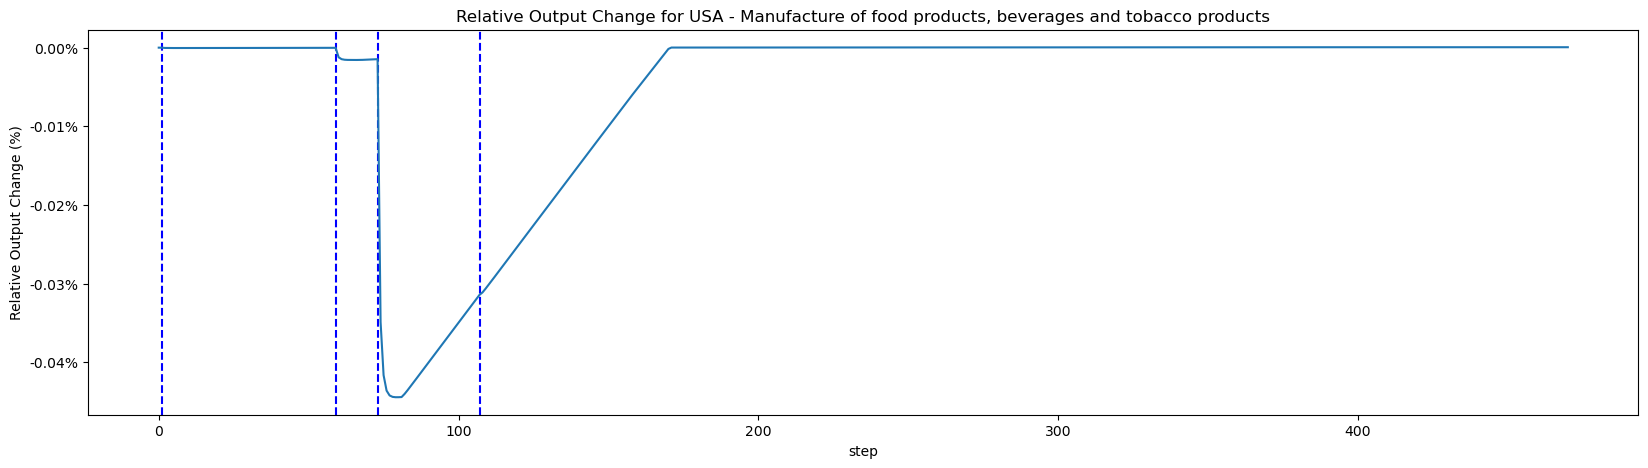

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5))

region = 'USA'
sector = "Manufacture of food products, beverages and tobacco products"

for occ in [(supchain.events_date[i] - supchain.events_date[0] + 1) for i in range(len(supchain.supchain_imp))]:
    plt.axvline(x=occ, color='b', linestyle="--")

relative_change = (supchain.supchain_imp['boario_recovery_agg'].loc[:, (region, sector)] -supchain.supchain_imp['boario_recovery_agg'].loc[0, (region, sector)]) / supchain.supchain_imp['boario_recovery_agg'].loc[0, (region, sector)]
relative_change.plot(ax=ax, legend=False)

# Adding y-axis label
plt.ylabel("Relative Output Change (%)")

# Converting y-axis ticks to percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

# Adding a title
plt.title(f"Relative Output Change for {region} - {sector}")

plt.show()


With the `boario_aggregate="sep"` version, results are a list of dataframe, with each dataframe showing impact from a single event.

In [41]:
supchain.calc_impacts(io_approach='boario',
                      boario_type = 'recovery',
                      boario_aggregate = 'sep',
                      boario_params={
                          "sim":{}, # We can leave that empty
                          "model":{ # See boario doc for the meaning of these parameters
                              "order_type":"noalt", 
                              "alpha_max":1.10,
                          }, # 
                          "event":{
                              "duration": 7, # This assumes the event spans over 7 steps (days) (recovery starts only after these)
                              "recovery_time":90 # This assumes the recovery takes 90 steps
                          },
                      }                    
                     )

Processed: Step: 471 ~ 100% Time:  0:01:25                 
Processed: Step: 471 ~ 100% Time:  0:01:44                 
Processed: Step: 471 ~ 100% Time:  0:01:51                 
Processed: Step: 471 ~ 100% Time:  0:01:44                 
Processed: Step: 471 ~ 100% Time:  0:01:44                 

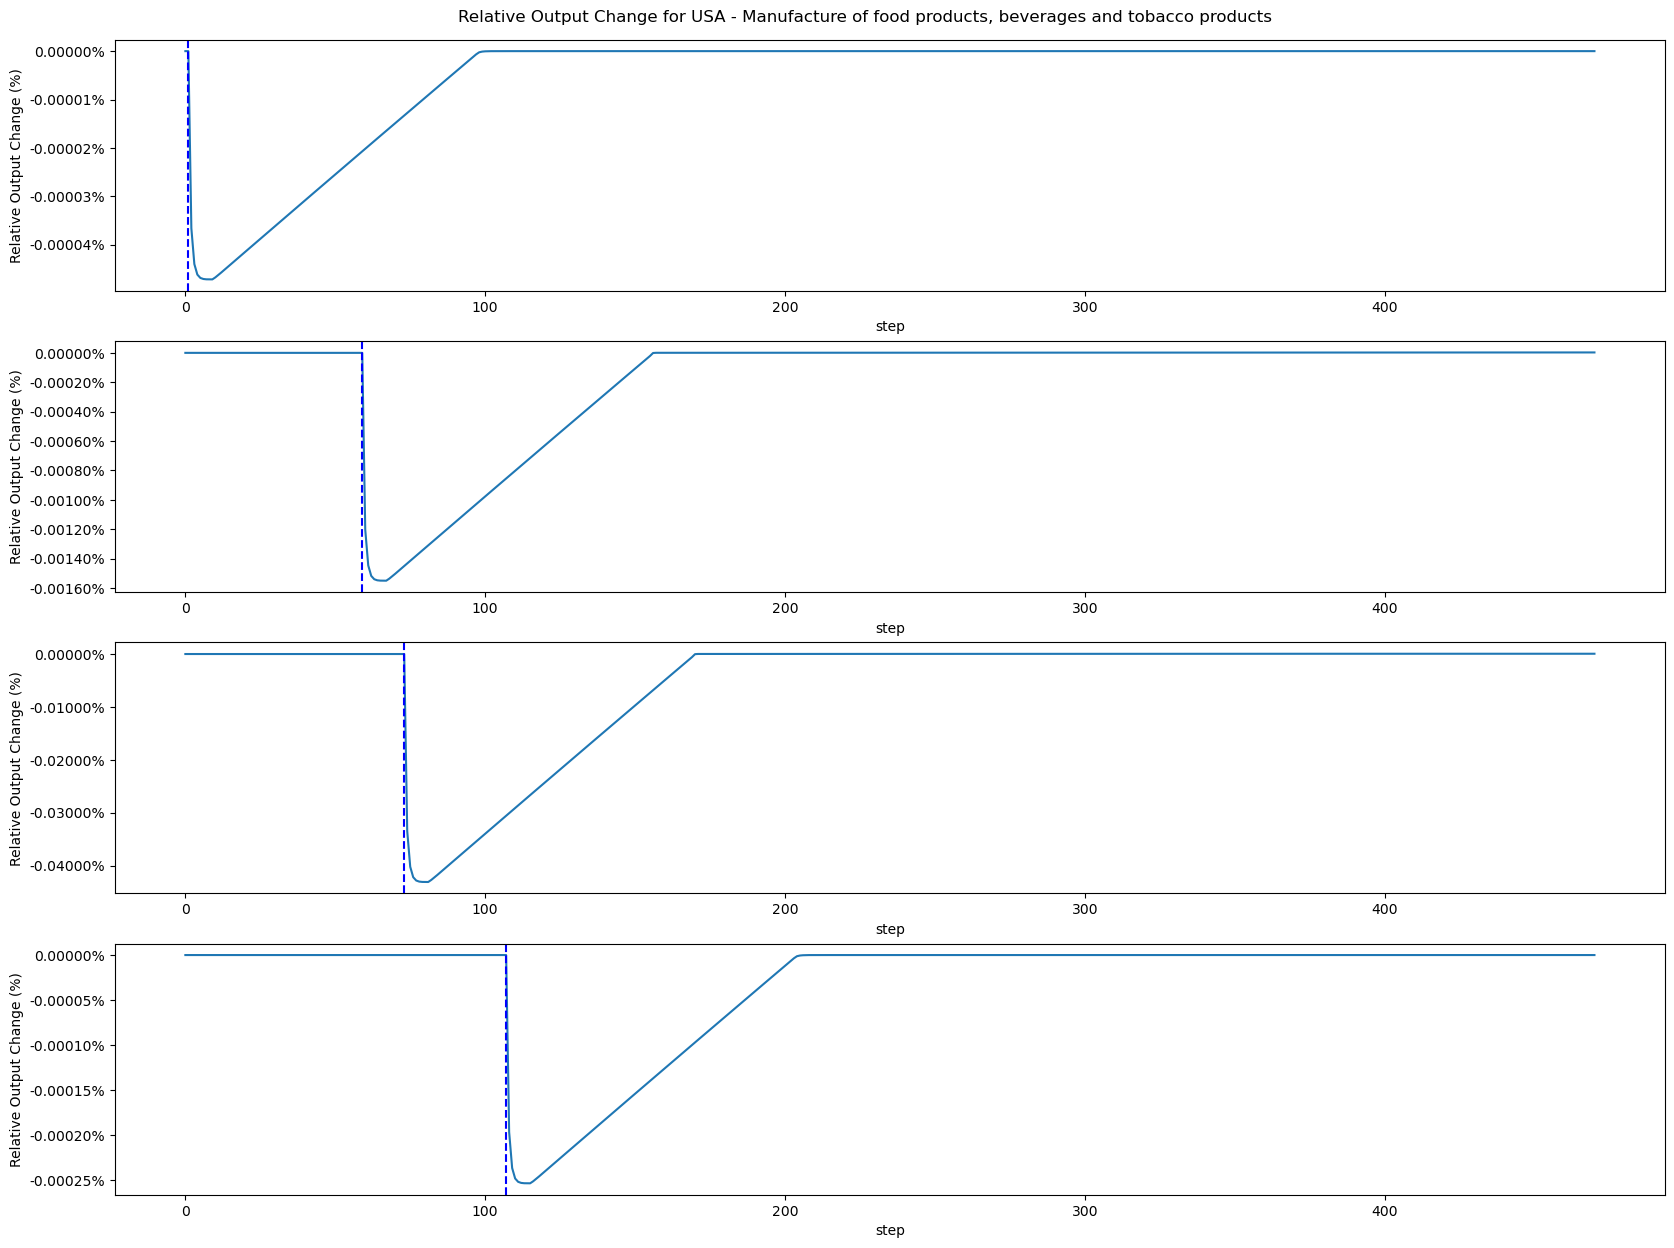

In [69]:
fig, ax = plt.subplots(len(supchain.events_date), 1, figsize=(20,15))

region = 'USA'
sector = "Manufacture of food products, beverages and tobacco products"

for i in range(len(supchain.events_date)):
    relative_change = (supchain.supchain_imp['boario_recovery_sep'][i].loc[:, (region, sector)] -supchain.supchain_imp['boario_recovery_sep'][i].loc[0, (region, sector)]) / supchain.supchain_imp['boario_recovery_agg'].loc[0, (region, sector)]
    relative_change.plot(ax=ax[i], legend=False)
    ax[i].axvline(x = supchain.events_date[i]-supchain.events_date[0] + 1, color = 'b', linestyle="--")
    ax[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.5%}'.format(x)))
    ax[i].set_ylabel("Relative Output Change (%)")

# Adding y-axis label


# Adding a title
plt.suptitle(f"Relative Output Change for {region} - {sector}",y=0.90)

plt.show()
